# [Comparison of FastText and Word2Vec](https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/Word2Vec_FastText_Comparison.ipynb)

Facebook Research open sourced a great project recently - [fastText](https://github.com/facebookresearch/fastText), a fast (no surprise) and effective method to learn word representations and perform text classification. I was curious about comparing these embeddings to other commonly used embeddings, so word2vec seemed like the obvious choice, especially considering fastText embeddings are an extension of word2vec. 

I've used gensim to train the word2vec models, and the analogical reasoning task (described in Section 4.1 of [[2]](https://arxiv.org/pdf/1301.3781v3.pdf)) for comparing the word2vec and fastText models. I've compared embeddings trained using the skipgram architecture.

# Download data

In [27]:
!rm -fr fastText

In [28]:
import nltk
from smart_open import smart_open
nltk.download('brown') 
# Only the brown corpus is needed in case you don't have it.

# Generate brown corpus text file
with smart_open('brown_corp.txt', 'w+') as f:
    for word in nltk.corpus.brown.words():
        f.write('{word} '.format(word=word))

# Make sure you set FT_HOME to your fastText directory root
!wget https://github.com/facebookresearch/fastText/archive/v0.9.2.zip
!unzip v0.9.2.zip && cd fastText-0.9.2 && make
!cd
FT_HOME = 'fastText-0.9.2/'
# download the text8 corpus (a 100 MB sample of cleaned wikipedia text)
import os.path
if not os.path.isfile('text8'):
    !wget -c http://mattmahoney.net/dc/text8.zip
    !unzip text8.zip
# download and preprocess the text9 corpus
if not os.path.isfile('text9'):
  !wget -c http://mattmahoney.net/dc/enwik9.zip
  !unzip enwik9.zip
  !perl {FT_HOME}wikifil.pl enwik9 > text9

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
--2021-05-26 11:31:50--  https://github.com/facebookresearch/fastText/archive/v0.9.2.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/facebookresearch/fastText/zip/v0.9.2 [following]
--2021-05-26 11:31:50--  https://codeload.github.com/facebookresearch/fastText/zip/v0.9.2
Resolving codeload.github.com (codeload.github.com)... 192.30.255.120
Connecting to codeload.github.com (codeload.github.com)|192.30.255.120|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘v0.9.2.zip’

v0.9.2.zip              [  <=>               ]   4.17M  13.9MB/s    in 0.3s    

2021-05-26 11:31:51 (13.9 MB/s) - ‘v0.9.2.zip’ saved [4369852]

Archive:  v0.9.2.zip
5b5943c118b0ec5fb

In [34]:
FT_HOME = 'fastText-0.9.2/'
!ls -lah {FT_HOME}fasttext --help

Usage: ls [OPTION]... [FILE]...
List information about the FILEs (the current directory by default).
Sort entries alphabetically if none of -cftuvSUX nor --sort is specified.

Mandatory arguments to long options are mandatory for short options too.
  -a, --all                  do not ignore entries starting with .
  -A, --almost-all           do not list implied . and ..
      --author               with -l, print the author of each file
  -b, --escape               print C-style escapes for nongraphic characters
      --block-size=SIZE      scale sizes by SIZE before printing them; e.g.,
                               '--block-size=M' prints sizes in units of
                               1,048,576 bytes; see SIZE format below
  -B, --ignore-backups       do not list implied entries ending with ~
  -c                         with -lt: sort by, and show, ctime (time of last
                               modification of file status information);
                               with -l:

# Train models

For training the models yourself, you'll need to have both [Gensim](https://github.com/RaRe-Technologies/gensim) and [FastText](https://github.com/facebookresearch/fastText) set up on your machine.

In [35]:
MODELS_DIR = 'models/'
!mkdir -p {MODELS_DIR}

lr = 0.05
dim = 100
ws = 5
epoch = 5
minCount = 5
neg = 5
loss = 'ns'
t = 1e-4

from gensim.models import Word2Vec, KeyedVectors
from gensim.models.word2vec import Text8Corpus

# Same values as used for fastText training above
params = {
    'alpha': lr,
    'size': dim,
    'window': ws,
    'iter': epoch,
    'min_count': minCount,
    'sample': t,
    'sg': 1,
    'hs': 0,
    'negative': neg
}

def train_models(corpus_file, output_name):
    output_file = '{:s}_ft'.format(output_name)
    if not os.path.isfile(os.path.join(MODELS_DIR, '{:s}.vec'.format(output_file))):
        print('Training fasttext on {:s} corpus..'.format(corpus_file))
        %time !{FT_HOME}fasttext skipgram -input {corpus_file} -output {MODELS_DIR+output_file}  -lr {lr} -dim {dim} -ws {ws} -epoch {epoch} -minCount {minCount} -neg {neg} -loss {loss} -t {t}
    else:
        print('\nUsing existing model file {:s}.vec'.format(output_file))
        
    output_file = '{:s}_ft_no_ng'.format(output_name)
    if not os.path.isfile(os.path.join(MODELS_DIR, '{:s}.vec'.format(output_file))):
        print('\nTraining fasttext on {:s} corpus (without char n-grams)..'.format(corpus_file))
        %time !{FT_HOME}fasttext skipgram -input {corpus_file} -output {MODELS_DIR+output_file}  -lr {lr} -dim {dim} -ws {ws} -epoch {epoch} -minCount {minCount} -neg {neg} -loss {loss} -t {t} -maxn 0
    else:
        print('\nUsing existing model file {:s}.vec'.format(output_file))
        
    output_file = '{:s}_gs'.format(output_name)
    if not os.path.isfile(os.path.join(MODELS_DIR, '{:s}.vec'.format(output_file))):
        print('\nTraining word2vec on {:s} corpus..'.format(corpus_file))
        
        # Text8Corpus class for reading space-separated words file
        %time gs_model = Word2Vec(Text8Corpus(corpus_file), **params); gs_model
        # Direct local variable lookup doesn't work properly with magic statements (%time)
        locals()['gs_model'].wv.save_word2vec_format(os.path.join(MODELS_DIR, '{:s}.vec'.format(output_file)))
        print('\nSaved gensim model as {:s}.vec'.format(output_file))
    else:
        print('\nUsing existing model file {:s}.vec'.format(output_file))

evaluation_data = {}
train_models('brown_corp.txt', 'brown')

Training fasttext on brown_corp.txt corpus..
Read 1M words
Number of words:  15173
Number of labels: 0
Progress: 100.0% words/sec/thread:   11356 lr:  0.000000 avg.loss:  2.361779 ETA:   0h 0m 0s
CPU times: user 624 ms, sys: 80.2 ms, total: 704 ms
Wall time: 48.1 s

Training fasttext on brown_corp.txt corpus (without char n-grams)..
Read 1M words
Number of words:  15173
Number of labels: 0
Progress: 100.0% words/sec/thread:   22274 lr:  0.000000 avg.loss:  2.432563 ETA:   0h 0m 0s
CPU times: user 265 ms, sys: 33.7 ms, total: 299 ms
Wall time: 22.7 s

Using existing model file brown_gs.vec


In [39]:
train_models(corpus_file='text8', output_name='text8')

Training fasttext on text8 corpus..
Read 17M words
Number of words:  71290
Number of labels: 0
Progress: 100.0% words/sec/thread:    8629 lr:  0.000000 avg.loss:  1.783013 ETA:   0h 0m 0s
CPU times: user 12.3 s, sys: 1.43 s, total: 13.7 s
Wall time: 13min 51s

Training fasttext on text8 corpus (without char n-grams)..
Read 17M words
Number of words:  71290
Number of labels: 0
Progress: 100.0% words/sec/thread:   16986 lr:  0.000000 avg.loss:  1.813725 ETA:   0h 0m 0s
CPU times: user 5.87 s, sys: 575 ms, total: 6.45 s
Wall time: 7min 1s

Training word2vec on text8 corpus..
CPU times: user 8min 53s, sys: 2.27 s, total: 8min 55s
Wall time: 4min 41s

Saved gensim model as text8_gs.vec


In [40]:
train_models(corpus_file='text9', output_name='text9')

Training fasttext on text9 corpus..
Read 124M words
Number of words:  218316
Number of labels: 0
Progress: 100.0% words/sec/thread:    9864 lr:  0.000000 avg.loss:  0.670973 ETA:   0h 0m 0s
CPU times: user 1min 14s, sys: 8.07 s, total: 1min 22s
Wall time: 1h 27min 55s

Training fasttext on text9 corpus (without char n-grams)..
Read 124M words
Number of words:  218316
Number of labels: 0
Progress: 100.0% words/sec/thread:   18267 lr:  0.000000 avg.loss:  0.660901 ETA:   0h 0m 0s
CPU times: user 38.2 s, sys: 4.12 s, total: 42.3 s
Wall time: 47min 31s

Training word2vec on text9 corpus..
CPU times: user 1h 3min 2s, sys: 13.3 s, total: 1h 3min 15s
Wall time: 32min 48s

Saved gensim model as text9_gs.vec


# Comparisons

In [41]:
# download the file questions-words.txt to be used for comparing word embeddings
!wget https://raw.githubusercontent.com/tmikolov/word2vec/master/questions-words.txt

--2021-05-26 15:22:32--  https://raw.githubusercontent.com/tmikolov/word2vec/master/questions-words.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 603955 (590K) [text/plain]
Saving to: ‘questions-words.txt’

questions-words.txt 100%[===================>] 589.80K  --.-KB/s    in 0.03s   

2021-05-26 15:22:32 (16.5 MB/s) - ‘questions-words.txt’ saved [603955/603955]



Once you have downloaded or trained the models and downloaded `questions-words.txt`, you're ready to run the comparison.

In [42]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# Training times in seconds
evaluation_data['brown'] = [(18, 54.3, 32.5)]
evaluation_data['text8'] = [(402, 942, 496)]
evaluation_data['text9'] = [(3218, 6589, 3550)]

def print_accuracy(model, questions_file):
    print('Evaluating...\n')
    acc = model.accuracy(questions_file)

    sem_correct = sum((len(acc[i]['correct']) for i in range(5)))
    sem_total = sum((len(acc[i]['correct']) + len(acc[i]['incorrect'])) for i in range(5))
    sem_acc = 100*float(sem_correct)/sem_total
    print('\nSemantic: {:d}/{:d}, Accuracy: {:.2f}%'.format(sem_correct, sem_total, sem_acc))
    
    syn_correct = sum((len(acc[i]['correct']) for i in range(5, len(acc)-1)))
    syn_total = sum((len(acc[i]['correct']) + len(acc[i]['incorrect'])) for i in range(5,len(acc)-1))
    syn_acc = 100*float(syn_correct)/syn_total
    print('Syntactic: {:d}/{:d}, Accuracy: {:.2f}%\n'.format(syn_correct, syn_total, syn_acc))
    return (sem_acc, syn_acc)

word_analogies_file = 'questions-words.txt'
accuracies = []
print('\nLoading Gensim embeddings')
brown_gs = KeyedVectors.load_word2vec_format(MODELS_DIR + 'brown_gs.vec')
print('Accuracy for Word2Vec:')
accuracies.append(print_accuracy(brown_gs, word_analogies_file))

print('\nLoading FastText embeddings')
brown_ft = KeyedVectors.load_word2vec_format(MODELS_DIR + 'brown_ft.vec')
print('Accuracy for FastText (with n-grams):')
accuracies.append(print_accuracy(brown_ft, word_analogies_file))

2021-05-26 15:23:46,130 : INFO : loading projection weights from models/brown_gs.vec



Loading Gensim embeddings


2021-05-26 15:23:47,550 : INFO : loaded (15173, 100) matrix from models/brown_gs.vec
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `accuracy` (Method will be removed in 4.0.0, use self.evaluate_word_analogies() instead).
  # This is added back by InteractiveShellApp.init_path()
2021-05-26 15:23:47,563 : INFO : precomputing L2-norms of word weight vectors
2021-05-26 15:23:47,746 : INFO : capital-common-countries: 4.4% (4/90)


Accuracy for Word2Vec:
Evaluating...



2021-05-26 15:23:47,856 : INFO : capital-world: 2.3% (1/44)
2021-05-26 15:23:47,887 : INFO : currency: 0.0% (0/12)
2021-05-26 15:23:48,760 : INFO : city-in-state: 0.7% (3/457)
2021-05-26 15:23:49,184 : INFO : family: 17.6% (37/210)
2021-05-26 15:23:50,601 : INFO : gram1-adjective-to-adverb: 0.4% (3/756)
2021-05-26 15:23:50,856 : INFO : gram2-opposite: 0.0% (0/132)
2021-05-26 15:23:52,827 : INFO : gram3-comparative: 3.3% (35/1056)
2021-05-26 15:23:53,236 : INFO : gram4-superlative: 0.0% (0/210)
2021-05-26 15:23:54,469 : INFO : gram5-present-participle: 0.2% (1/650)
2021-05-26 15:23:55,033 : INFO : gram6-nationality-adjective: 3.4% (10/297)
2021-05-26 15:23:57,409 : INFO : gram7-past-tense: 1.1% (14/1260)
2021-05-26 15:23:58,488 : INFO : gram8-plural: 5.6% (31/552)
2021-05-26 15:23:59,138 : INFO : gram9-plural-verbs: 2.3% (8/342)
2021-05-26 15:23:59,144 : INFO : total: 2.4% (147/6068)
2021-05-26 15:23:59,152 : INFO : loading projection weights from models/brown_ft.vec



Semantic: 45/813, Accuracy: 5.54%
Syntactic: 102/5255, Accuracy: 1.94%


Loading FastText embeddings


2021-05-26 15:24:00,600 : INFO : loaded (15173, 100) matrix from models/brown_ft.vec
2021-05-26 15:24:00,612 : INFO : precomputing L2-norms of word weight vectors


Accuracy for FastText (with n-grams):
Evaluating...



2021-05-26 15:24:00,809 : INFO : capital-common-countries: 2.2% (2/90)
2021-05-26 15:24:00,916 : INFO : capital-world: 0.0% (0/44)
2021-05-26 15:24:00,948 : INFO : currency: 0.0% (0/12)
2021-05-26 15:24:01,859 : INFO : city-in-state: 2.6% (12/457)
2021-05-26 15:24:02,269 : INFO : family: 18.6% (39/210)
2021-05-26 15:24:03,731 : INFO : gram1-adjective-to-adverb: 68.8% (520/756)
2021-05-26 15:24:03,989 : INFO : gram2-opposite: 80.3% (106/132)
2021-05-26 15:24:06,048 : INFO : gram3-comparative: 62.3% (658/1056)
2021-05-26 15:24:06,469 : INFO : gram4-superlative: 74.8% (157/210)
2021-05-26 15:24:07,703 : INFO : gram5-present-participle: 69.5% (452/650)
2021-05-26 15:24:08,292 : INFO : gram6-nationality-adjective: 31.0% (92/297)
2021-05-26 15:24:10,699 : INFO : gram7-past-tense: 11.3% (143/1260)
2021-05-26 15:24:11,749 : INFO : gram8-plural: 52.9% (292/552)
2021-05-26 15:24:12,391 : INFO : gram9-plural-verbs: 73.4% (251/342)
2021-05-26 15:24:12,394 : INFO : total: 44.9% (2724/6068)



Semantic: 53/813, Accuracy: 6.52%
Syntactic: 2671/5255, Accuracy: 50.83%



The `accuracy` takes an optional parameter `restrict_vocab`, which limits the vocabulary of model considered for fast approximate evaluation (default is 30000).

~~Word2Vec embeddings seem to be slightly better than fastText embeddings at the semantic tasks~~, while the fastText embeddings do significantly better on the syntactic analogies. Makes sense, since fastText embeddings are trained for understanding morphological nuances, and most of the syntactic analogies are morphology based. 

Let me explain that better.

According to the paper [[1]](https://arxiv.org/abs/1607.04606), embeddings for words are represented by the sum of their n-gram embeddings. This is meant to be useful for morphologically rich languages - so theoretically, the embedding for `apparently` would include information from both character n-grams `apparent` and `ly` (as well as other n-grams), and the n-grams would combine in a simple, linear manner. This is very similar to what most of our syntactic tasks look like.

Example analogy:

`amazing amazingly calm calmly`

This analogy is marked correct if: 

`embedding(amazing)` - `embedding(amazingly)` = `embedding(calm)` - `embedding(calmly)`

Both these subtractions would result in a very similar set of remaining ngrams.
No surprise the fastText embeddings do extremely well on this.

Let's do a small test to validate this hypothesis - fastText differs from word2vec only in that it uses char n-gram embeddings as well as the actual word embedding in the scoring function to calculate scores and then likelihoods for each word, given a context word. In case char n-gram embeddings are not present, this reduces (at least theoretically) to the original word2vec model. This can be implemented by setting 0 for the max length of char n-grams for fastText.


In [43]:
print('Loading FastText embeddings')
brown_ft_no_ng = KeyedVectors.load_word2vec_format(MODELS_DIR + 'brown_ft_no_ng.vec')
print('Accuracy for FastText (without n-grams):')
accuracies.append(print_accuracy(brown_ft_no_ng, word_analogies_file))
evaluation_data['brown'] += [[acc[0] for acc in accuracies], [acc[1] for acc in accuracies]]

2021-05-26 15:34:26,046 : INFO : loading projection weights from models/brown_ft_no_ng.vec


Loading FastText embeddings


2021-05-26 15:34:27,478 : INFO : loaded (15173, 100) matrix from models/brown_ft_no_ng.vec
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `accuracy` (Method will be removed in 4.0.0, use self.evaluate_word_analogies() instead).
  # This is added back by InteractiveShellApp.init_path()
2021-05-26 15:34:27,491 : INFO : precomputing L2-norms of word weight vectors
2021-05-26 15:34:27,670 : INFO : capital-common-countries: 4.4% (4/90)


Accuracy for FastText (without n-grams):
Evaluating...



2021-05-26 15:34:27,788 : INFO : capital-world: 0.0% (0/44)
2021-05-26 15:34:27,818 : INFO : currency: 0.0% (0/12)
2021-05-26 15:34:28,694 : INFO : city-in-state: 1.8% (8/457)
2021-05-26 15:34:29,089 : INFO : family: 15.7% (33/210)
2021-05-26 15:34:30,488 : INFO : gram1-adjective-to-adverb: 0.4% (3/756)
2021-05-26 15:34:30,743 : INFO : gram2-opposite: 0.0% (0/132)
2021-05-26 15:34:32,729 : INFO : gram3-comparative: 1.7% (18/1056)
2021-05-26 15:34:33,129 : INFO : gram4-superlative: 0.0% (0/210)
2021-05-26 15:34:34,365 : INFO : gram5-present-participle: 0.3% (2/650)
2021-05-26 15:34:34,933 : INFO : gram6-nationality-adjective: 3.4% (10/297)
2021-05-26 15:34:37,331 : INFO : gram7-past-tense: 1.7% (21/1260)
2021-05-26 15:34:38,361 : INFO : gram8-plural: 6.7% (37/552)
2021-05-26 15:34:39,029 : INFO : gram9-plural-verbs: 1.8% (6/342)
2021-05-26 15:34:39,031 : INFO : total: 2.3% (142/6068)



Semantic: 45/813, Accuracy: 5.54%
Syntactic: 97/5255, Accuracy: 1.85%



A-ha! The results for FastText with no n-grams and Word2Vec look a lot more similar (as they should) - the differences could easily result from differences in implementation between fastText and Gensim, and randomization. ~~Especially telling is that the semantic accuracy for FastText has improved slightly after removing n-grams~~, while the syntactic accuracy has taken a giant dive. Our hypothesis that the char n-grams result in better performance on syntactic analogies seems fair. ~~It also seems possible that char n-grams hurt semantic accuracy a little~~. However, the brown corpus is too small to be able to draw any definite conclusions - the accuracies seem to vary significantly over different runs.

Let's try with a larger corpus now - text8 (collection of wiki articles). I'm also curious about the impact on semantic accuracy - for models trained on the brown corpus, the difference in the semantic accuracy and the accuracy values themselves are too small to be conclusive. Hopefully a larger corpus helps, and the text8 corpus likely has a lot more information about capitals, currencies, cities etc, which should be relevant to the semantic tasks.

In [44]:
accuracies = []
print('Loading Gensim embeddings')
text8_gs = KeyedVectors.load_word2vec_format(MODELS_DIR + 'text8_gs.vec')
print('Accuracy for word2vec:')
accuracies.append(print_accuracy(text8_gs, word_analogies_file))

print('Loading FastText embeddings (with n-grams)')
text8_ft = KeyedVectors.load_word2vec_format(MODELS_DIR + 'text8_ft.vec')
print('Accuracy for FastText (with n-grams):')
accuracies.append(print_accuracy(text8_ft, word_analogies_file))

print('Loading FastText embeddings')
text8_ft_no_ng = KeyedVectors.load_word2vec_format(MODELS_DIR + 'text8_ft_no_ng.vec')
print('Accuracy for FastText (without n-grams):')
accuracies.append(print_accuracy(text8_ft_no_ng, word_analogies_file))

evaluation_data['text8'] += [[acc[0] for acc in accuracies], [acc[1] for acc in accuracies]]

2021-05-26 15:44:08,230 : INFO : loading projection weights from models/text8_gs.vec


Loading Gensim embeddings


2021-05-26 15:44:14,596 : INFO : loaded (71290, 100) matrix from models/text8_gs.vec
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `accuracy` (Method will be removed in 4.0.0, use self.evaluate_word_analogies() instead).
  # This is added back by InteractiveShellApp.init_path()
2021-05-26 15:44:14,724 : INFO : precomputing L2-norms of word weight vectors


Accuracy for word2vec:
Evaluating...



2021-05-26 15:44:16,643 : INFO : capital-common-countries: 66.0% (334/506)
2021-05-26 15:44:22,139 : INFO : capital-world: 44.4% (644/1452)
2021-05-26 15:44:23,130 : INFO : currency: 20.1% (54/268)
2021-05-26 15:44:28,967 : INFO : city-in-state: 24.1% (378/1571)
2021-05-26 15:44:30,103 : INFO : family: 57.5% (176/306)
2021-05-26 15:44:32,891 : INFO : gram1-adjective-to-adverb: 15.1% (114/756)
2021-05-26 15:44:34,044 : INFO : gram2-opposite: 13.1% (40/306)
2021-05-26 15:44:38,780 : INFO : gram3-comparative: 52.5% (662/1260)
2021-05-26 15:44:40,626 : INFO : gram4-superlative: 26.7% (135/506)
2021-05-26 15:44:44,265 : INFO : gram5-present-participle: 25.1% (249/992)
2021-05-26 15:44:49,242 : INFO : gram6-nationality-adjective: 78.6% (1078/1371)
2021-05-26 15:44:54,083 : INFO : gram7-past-tense: 34.7% (462/1332)
2021-05-26 15:44:57,690 : INFO : gram8-plural: 48.5% (481/992)
2021-05-26 15:45:00,078 : INFO : gram9-plural-verbs: 24.8% (161/650)
2021-05-26 15:45:00,080 : INFO : total: 40.5% (4


Semantic: 1586/4103, Accuracy: 38.65%
Syntactic: 3382/8165, Accuracy: 41.42%

Loading FastText embeddings (with n-grams)


2021-05-26 15:45:06,587 : INFO : loaded (71290, 100) matrix from models/text8_ft.vec
2021-05-26 15:45:06,613 : INFO : precomputing L2-norms of word weight vectors


Accuracy for FastText (with n-grams):
Evaluating...



2021-05-26 15:45:08,529 : INFO : capital-common-countries: 65.2% (330/506)
2021-05-26 15:45:13,998 : INFO : capital-world: 43.7% (635/1452)
2021-05-26 15:45:15,015 : INFO : currency: 12.7% (34/268)
2021-05-26 15:45:20,628 : INFO : city-in-state: 17.1% (258/1511)
2021-05-26 15:45:21,776 : INFO : family: 51.6% (158/306)
2021-05-26 15:45:24,583 : INFO : gram1-adjective-to-adverb: 73.4% (555/756)
2021-05-26 15:45:25,721 : INFO : gram2-opposite: 56.9% (174/306)
2021-05-26 15:45:30,400 : INFO : gram3-comparative: 70.2% (885/1260)
2021-05-26 15:45:32,276 : INFO : gram4-superlative: 61.5% (311/506)
2021-05-26 15:45:36,014 : INFO : gram5-present-participle: 59.7% (592/992)
2021-05-26 15:45:41,126 : INFO : gram6-nationality-adjective: 92.8% (1272/1371)
2021-05-26 15:45:46,168 : INFO : gram7-past-tense: 37.2% (496/1332)
2021-05-26 15:45:49,869 : INFO : gram8-plural: 85.6% (849/992)
2021-05-26 15:45:52,442 : INFO : gram9-plural-verbs: 61.1% (397/650)
2021-05-26 15:45:52,446 : INFO : total: 56.9% (


Semantic: 1415/4043, Accuracy: 35.00%
Syntactic: 5531/8165, Accuracy: 67.74%

Loading FastText embeddings


2021-05-26 15:45:59,112 : INFO : loaded (71290, 100) matrix from models/text8_ft_no_ng.vec
2021-05-26 15:45:59,139 : INFO : precomputing L2-norms of word weight vectors


Accuracy for FastText (without n-grams):
Evaluating...



2021-05-26 15:46:01,114 : INFO : capital-common-countries: 68.2% (345/506)
2021-05-26 15:46:06,465 : INFO : capital-world: 45.0% (653/1452)
2021-05-26 15:46:07,457 : INFO : currency: 19.0% (51/268)
2021-05-26 15:46:13,049 : INFO : city-in-state: 21.4% (323/1511)
2021-05-26 15:46:14,174 : INFO : family: 58.8% (180/306)
2021-05-26 15:46:16,979 : INFO : gram1-adjective-to-adverb: 16.3% (123/756)
2021-05-26 15:46:18,128 : INFO : gram2-opposite: 14.1% (43/306)
2021-05-26 15:46:22,747 : INFO : gram3-comparative: 48.1% (606/1260)
2021-05-26 15:46:24,640 : INFO : gram4-superlative: 24.5% (124/506)
2021-05-26 15:46:28,245 : INFO : gram5-present-participle: 23.7% (235/992)
2021-05-26 15:46:33,241 : INFO : gram6-nationality-adjective: 82.6% (1132/1371)
2021-05-26 15:46:38,115 : INFO : gram7-past-tense: 29.3% (390/1332)
2021-05-26 15:46:41,725 : INFO : gram8-plural: 50.0% (496/992)
2021-05-26 15:46:44,087 : INFO : gram9-plural-verbs: 26.3% (171/650)
2021-05-26 15:46:44,093 : INFO : total: 39.9% (4


Semantic: 1552/4043, Accuracy: 38.39%
Syntactic: 3320/8165, Accuracy: 40.66%



With the text8 corpus, we observe a similar pattern. ~~Semantic accuracy falls by a small but significant amount when n-grams are included in FastText~~, while FastText with n-grams performs far better on the syntactic analogies. FastText without n-grams are largely similar to Word2Vec.

My hypothesis for semantic accuracy being lower for the FastText-with-ngrams model is that most of the words in the semantic analogies are standalone words and are unrelated to their morphemes (eg: father, mother, France, Paris), hence inclusion of the char n-grams into the scoring function actually makes the embeddings worse.

This trend is observed in the original paper too where the performance of embeddings with n-grams is worse on semantic tasks than both word2vec cbow and skipgram models.

Let's do a quick comparison on an even larger corpus - text9 

In [45]:
accuracies = []
print('Loading Gensim embeddings')
text9_gs = KeyedVectors.load_word2vec_format(MODELS_DIR + 'text9_gs.vec')
print('Accuracy for word2vec:')
accuracies.append(print_accuracy(text9_gs, word_analogies_file))

print('Loading FastText embeddings (with n-grams)')
text9_ft = KeyedVectors.load_word2vec_format(MODELS_DIR + 'text9_ft.vec')
print('Accuracy for FastText (with n-grams):')
accuracies.append(print_accuracy(text9_ft, word_analogies_file))

print('Loading FastText embeddings')
text9_ft_no_ng = KeyedVectors.load_word2vec_format(MODELS_DIR + 'text9_ft_no_ng.vec')
print('Accuracy for FastText (without n-grams):')
accuracies.append(print_accuracy(text9_ft_no_ng, word_analogies_file))

evaluation_data['text9'] += [[acc[0] for acc in accuracies], [acc[1] for acc in accuracies]]

2021-05-26 15:50:21,740 : INFO : loading projection weights from models/text9_gs.vec


Loading Gensim embeddings


2021-05-26 15:50:42,863 : INFO : loaded (218316, 100) matrix from models/text9_gs.vec
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `accuracy` (Method will be removed in 4.0.0, use self.evaluate_word_analogies() instead).
  # This is added back by InteractiveShellApp.init_path()
2021-05-26 15:50:42,890 : INFO : precomputing L2-norms of word weight vectors


Accuracy for word2vec:
Evaluating...



2021-05-26 15:50:45,354 : INFO : capital-common-countries: 85.6% (433/506)
2021-05-26 15:50:51,700 : INFO : capital-world: 75.6% (1237/1636)
2021-05-26 15:50:52,395 : INFO : currency: 21.3% (38/178)
2021-05-26 15:51:00,454 : INFO : city-in-state: 40.4% (861/2133)
2021-05-26 15:51:01,929 : INFO : family: 69.7% (265/380)
2021-05-26 15:51:04,967 : INFO : gram1-adjective-to-adverb: 28.1% (228/812)
2021-05-26 15:51:06,319 : INFO : gram2-opposite: 36.3% (124/342)
2021-05-26 15:51:11,082 : INFO : gram3-comparative: 66.9% (843/1260)
2021-05-26 15:51:12,994 : INFO : gram4-superlative: 56.3% (285/506)
2021-05-26 15:51:16,509 : INFO : gram5-present-participle: 51.6% (480/930)
2021-05-26 15:51:21,734 : INFO : gram6-nationality-adjective: 89.9% (1232/1371)
2021-05-26 15:51:26,738 : INFO : gram7-past-tense: 48.0% (639/1332)
2021-05-26 15:51:30,751 : INFO : gram8-plural: 74.1% (783/1056)
2021-05-26 15:51:33,364 : INFO : gram9-plural-verbs: 47.0% (330/702)
2021-05-26 15:51:33,366 : INFO : total: 59.2%


Semantic: 2834/4833, Accuracy: 58.64%
Syntactic: 4944/8311, Accuracy: 59.49%

Loading FastText embeddings (with n-grams)


2021-05-26 15:51:53,641 : INFO : loaded (218316, 100) matrix from models/text9_ft.vec
2021-05-26 15:51:53,673 : INFO : precomputing L2-norms of word weight vectors


Accuracy for FastText (with n-grams):
Evaluating...



2021-05-26 15:51:56,111 : INFO : capital-common-countries: 83.8% (424/506)
2021-05-26 15:52:02,220 : INFO : capital-world: 71.9% (1177/1636)
2021-05-26 15:52:02,892 : INFO : currency: 19.7% (35/178)
2021-05-26 15:52:10,808 : INFO : city-in-state: 36.2% (773/2133)
2021-05-26 15:52:12,243 : INFO : family: 63.2% (240/380)
2021-05-26 15:52:15,282 : INFO : gram1-adjective-to-adverb: 53.6% (435/812)
2021-05-26 15:52:16,558 : INFO : gram2-opposite: 52.3% (179/342)
2021-05-26 15:52:21,293 : INFO : gram3-comparative: 73.3% (923/1260)
2021-05-26 15:52:23,196 : INFO : gram4-superlative: 65.4% (331/506)
2021-05-26 15:52:26,731 : INFO : gram5-present-participle: 57.0% (530/930)
2021-05-26 15:52:31,862 : INFO : gram6-nationality-adjective: 96.0% (1316/1371)
2021-05-26 15:52:36,775 : INFO : gram7-past-tense: 48.5% (646/1332)
2021-05-26 15:52:40,665 : INFO : gram8-plural: 84.2% (889/1056)
2021-05-26 15:52:43,289 : INFO : gram9-plural-verbs: 54.3% (381/702)
2021-05-26 15:52:43,291 : INFO : total: 63.0%


Semantic: 2649/4833, Accuracy: 54.81%
Syntactic: 5630/8311, Accuracy: 67.74%

Loading FastText embeddings


2021-05-26 15:53:03,156 : INFO : loaded (218316, 100) matrix from models/text9_ft_no_ng.vec
2021-05-26 15:53:03,191 : INFO : precomputing L2-norms of word weight vectors


Accuracy for FastText (without n-grams):
Evaluating...



2021-05-26 15:53:05,683 : INFO : capital-common-countries: 88.9% (450/506)
2021-05-26 15:53:11,834 : INFO : capital-world: 75.4% (1234/1636)
2021-05-26 15:53:12,505 : INFO : currency: 18.5% (33/178)
2021-05-26 15:53:20,477 : INFO : city-in-state: 33.5% (714/2133)
2021-05-26 15:53:21,924 : INFO : family: 59.7% (227/380)
2021-05-26 15:53:24,993 : INFO : gram1-adjective-to-adverb: 28.4% (231/812)
2021-05-26 15:53:26,282 : INFO : gram2-opposite: 34.8% (119/342)
2021-05-26 15:53:30,978 : INFO : gram3-comparative: 67.4% (849/1260)
2021-05-26 15:53:32,846 : INFO : gram4-superlative: 54.0% (273/506)
2021-05-26 15:53:36,321 : INFO : gram5-present-participle: 48.5% (451/930)
2021-05-26 15:53:41,404 : INFO : gram6-nationality-adjective: 92.5% (1268/1371)
2021-05-26 15:53:46,378 : INFO : gram7-past-tense: 46.4% (618/1332)
2021-05-26 15:53:50,314 : INFO : gram8-plural: 75.3% (795/1056)
2021-05-26 15:53:52,884 : INFO : gram9-plural-verbs: 43.7% (307/702)
2021-05-26 15:53:52,890 : INFO : total: 57.6%


Semantic: 2658/4833, Accuracy: 55.00%
Syntactic: 4911/8311, Accuracy: 59.09%



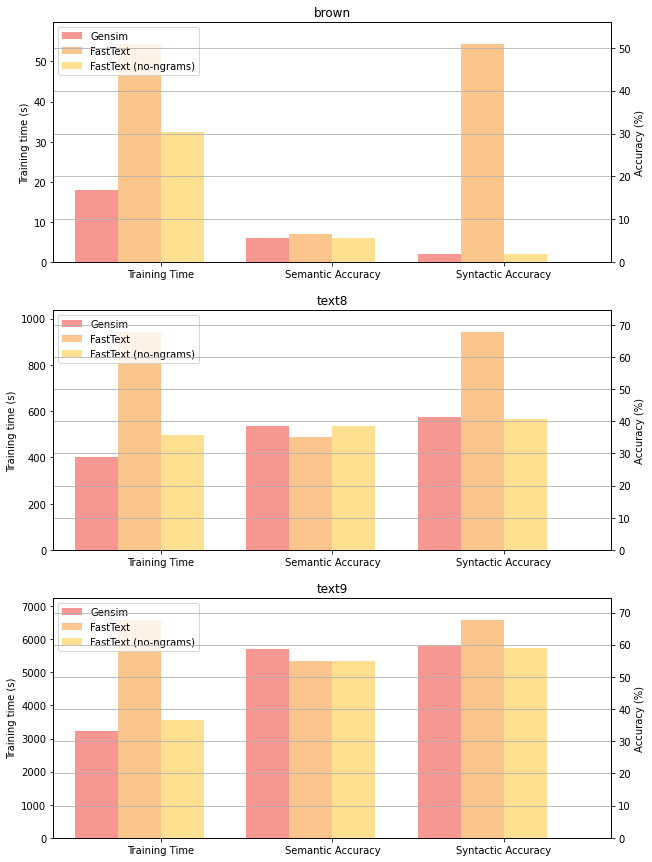

In [46]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot(ax, data, corpus_name='brown'):
    width = 0.25
    pos = [(i, i + width, i + 2*width) for i in range(len(data))]
    colors = ['#EE3224', '#F78F1E', '#FFC222']
    acc_ax = ax.twinx()
    # Training time
    ax.bar(pos[0],
            data[0],
            width,
            alpha=0.5,
            color=colors
            )
    # Semantic accuracy
    acc_ax.bar(pos[1],
            data[1],
            width,
            alpha=0.5,
            color=colors
            )

    # Syntactic accuracy
    acc_ax.bar(pos[2],
            data[2],
            width,
            alpha=0.5,
            color=colors
            )

    ax.set_ylabel('Training time (s)')
    acc_ax.set_ylabel('Accuracy (%)')
    ax.set_title(corpus_name)

    acc_ax.set_xticks([p[0] + 1.5 * width for p in pos])
    acc_ax.set_xticklabels(['Training Time', 'Semantic Accuracy', 'Syntactic Accuracy'])

    # Proxy plots for adding legend correctly
    proxies = [ax.bar([0], [0], width=0, color=c, alpha=0.5)[0] for c in colors]
    models = ('Gensim', 'FastText', 'FastText (no-ngrams)')
    ax.legend((proxies), models, loc='upper left')
    
    ax.set_xlim(pos[0][0]-width, pos[-1][0]+width*4)
    ax.set_ylim([0, max(data[0])*1.1] )
    acc_ax.set_ylim([0, max(data[1] + data[2])*1.1] )

    plt.grid()

# Plotting the bars
fig = plt.figure(figsize=(10,15))
for corpus, subplot in zip(sorted(evaluation_data.keys()), [311, 312, 313]):
    ax = fig.add_subplot(subplot)
    plot(ax, evaluation_data[corpus], corpus)

plt.show()

The results from text9 seem to confirm our hypotheses so far. Briefly summarising the main points -

1. FastText models with n-grams do significantly better on syntactic tasks, because of the syntactic questions being related to morphology of the words
2. Both Gensim word2vec and the fastText model with no n-grams do slightly better on the semantic tasks, presumably because words from the semantic questions are standalone words and unrelated to their char n-grams
3. In general, the performance of the models seems to get closer with the increasing corpus size. However, this might possibly be due to the size of the model staying constant at 100, and a larger model size for large corpora might result in higher performance gains.
4. The semantic accuracy for all models increases significantly with the increase in corpus size.
5. However, the increase in syntactic accuracy from the increase in corpus size for the n-gram FastText model is lower (in both relative and absolute terms). This could possibly indicate that advantages gained by incorporating morphological information could be less significant in case of larger corpus sizes (the corpuses used in the original paper seem to indicate this too)
6. Training times for gensim are slightly lower than the fastText no-ngram model, and significantly lower than the n-gram variant. This is quite impressive considering fastText is implemented in C++ and Gensim in Python (with calls to low-level BLAS routines for much of the heavy lifting). You could read [this post](http://rare-technologies.com/word2vec-in-python-part-two-optimizing/) for more details regarding word2vec optimisation in Gensim. Note that these times include importing any dependencies and serializing the models to disk, and not just the training times.

# Conclusions

These preliminary results seem to indicate fastText embeddings are significantly better than word2vec at encoding syntactic information. This is expected, since most syntactic analogies are morphology based, and the char n-gram approach of fastText takes such information into account. The original word2vec model seems to perform better on semantic tasks, since words in semantic analogies are unrelated to their char n-grams, and the added information from irrelevant char n-grams worsens the embeddings. It'd be interesting to see how transferable these embeddings are for different kinds of tasks by comparing their performance in a downstream supervised task.

# References

[1] [Enriching Word Vectors with Subword Information](https://arxiv.org/pdf/1607.04606v1.pdf)

[2] [Efficient Estimation of Word Representations in Vector Space](https://arxiv.org/pdf/1301.3781v3.pdf)
